In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


**PROBLEM 2 CHECKS**

In [ ]:
# 1. Define the point and gradient function
x0 = np.array([1.0, 2.0, -1.0])
alpha_star = 0.76974 # Given in HW 3 

def get_grad(x):
    # f(x1, x2, x3) = x1 * x2^2 * x3^2 -x2 * x3^3
    # grad = [x2^2x3^2, 2x1x2x3^2 - x3^3, 2x1x2^2x3 - 3x2x3^2]
    return np.array([x[1]**2 * x[2]**2, 2*x[0]*x[1]*x[2]**2 - x[2]**3, 2*x[0]*x[1]**2*x[2] - 3*x[1]*x[2]**2])

# --- STEP 1: INITIAL DIRECTION p0 ---
grad0 = get_grad(x0)
norm0_sq = np.dot(grad0, grad0)
norm0 = np.linalg.norm(grad0)
p0 = -grad0 / norm0 # Non-linear CG update 

print(f"--- Step 1: x0 = {x0} ---")
print(f"Gradient 0: {grad0}")
print(f"grad0^T * grad0 (Denominator for Beta): {norm0_sq:.4f}")
print(f"Norm 0: {norm0:.4f}")
print(f"Search Direction p0: {p0}\n")

# --- STEP 2: UPDATE POSITION TO x1 ---
x1 = x0 + alpha_star * p0 
print(f"--- Step 2: Move to x1 ---")
print(f"x1 = x0 + alpha* * p0: {x1}\n")

# --- STEP 3: SECOND DIRECTION p1 ---
grad1 = get_grad(x1)
norm1_sq = np.dot(grad1, grad1)
norm1 = np.linalg.norm(grad1)

# Fletcher-Reeves Formula: Beta = (g1^T * g1) / (g0^T * g0)
beta1 = norm1_sq / norm0_sq

# Direction p1 = -grad1/||grad1|| + beta1 * p0 
p1 = (-grad1 / norm1) + (beta1 * p0)

print(f"--- Step 3: Calculate p1 at x1 ---")
print(f"Gradient 1: {grad1}")
print(f"grad1^T * grad1 (Numerator for Beta): {norm1_sq:.4f}")
print(f"grad0^T * grad0 (Denominator for Beta): {norm0_sq:.4f}")
print(f"Beta 1 (Fletcher-Reeves): {beta1:.4f}")
print(f"Norm 1: {norm1:.4f}")
print(f"Normalized Descent Part (-g1/||g1||): {-grad1/norm1}")
print(f"Conjugate Part (beta1 * p0): {beta1 * p0}")
print(f"Search Direction p1: {p1}")


--- Step 1: x0 = [ 1.  2. -1.] ---
Gradient 0: [  4.   5. -14.]
grad0^T * grad0 (Denominator for Beta): 237.0000
Norm 0: 15.3948
Search Direction p0: [-0.25982792 -0.3247849   0.90939772]

--- Step 2: Move to x1 ---
x1 = x0 + alpha* * p0: [ 0.80000006  1.75000007 -0.3000002 ]

--- Step 3: Calculate p1 at x1 ---
Gradient 1: [ 0.27562538  0.27900041 -1.94250182]
X_1: [ 0.80000006  1.75000007 -0.3000002 ]
grad1^T * grad1 (Numerator for Beta): 3.9271
grad0^T * grad0 (Denominator for Beta): 237.0000
Beta 1 (Fletcher-Reeves): 0.0166
Norm 1: 1.9817
Normalized Descent Part (-g1/||g1||): [-0.13908552 -0.14078862  0.98022129]
Conjugate Part (beta1 * p0): [-0.00430539 -0.00538173  0.01506885]
Search Direction p1: [-0.1433909  -0.14617035  0.99529014]


**PROBLEM 3**

recycled algorithms

In [3]:
# --- HW 2 STUFF  ---

def calculate_beta1(a1, a2, phi1, phi2, dphi1, dphi2):
    return dphi1 + dphi2 - 3 * (phi1 - phi2) / (a1 - a2)

def calculate_beta2(a1, a2, phi1, phi2, dphi1, dphi2, beta1):    
    return np.sign(a2 - a1) * np.sqrt(max(0, beta1**2 - dphi1 * dphi2))

def interpolate_minimum_alpha(a1, a2, phi1, phi2, dphi1, dphi2):    
    b1 = calculate_beta1(a1, a2, phi1, phi2, dphi1, dphi2)
    b2 = calculate_beta2(a1, a2, phi1, phi2, dphi1, dphi2, b1)

    num = dphi2 + b2 - b1
    den = dphi2 - dphi1 + 2 * b2

    if abs(den) < 1e-12: 
        return a1 + (a2 - a1) / 2.0
    
    return a2 - (a2 - a1) * (num / den)

def pinpoint(a_low, a_high, phi_0, dphi_0, phi_low, dphi_low, mu1, mu2, func_phi):    
    while True:
        phi_high, dphi_high = func_phi(a_high)

        ap = interpolate_minimum_alpha(a_low, a_high, phi_low, phi_high, dphi_low, dphi_high)
        phi_p, dphi_p = func_phi(ap)

        if phi_p > (phi_0 + mu1 * ap * dphi_0) or phi_p >= phi_low:
            a_high = ap
        else:
            if abs(dphi_p) <= -mu2 * dphi_0: 
                return ap
            if dphi_p * (a_high - a_low) >= 0: 
                a_high = a_low

            a_low, phi_low, dphi_low = ap, phi_p, dphi_p

def line_search(x, p, fun, grad, mu1=1e-4, mu2=0.1, sigma=2.0):    
    def phi_alpha(alpha):
        x_curr = x + alpha * p
        return fun(x_curr), np.dot(grad(x_curr), p)
    
    a1, a2 = 0.0, 1.0
    phi_0, dphi_0 = phi_alpha(0.0)
    phi1, dphi1 = phi_0, dphi_0

    first = True
    while True:
        phi2, dphi2 = phi_alpha(a2)

        if (phi2 > phi_0 + mu1 * a2 * dphi_0) or (not first and phi2 >= phi1):
            return pinpoint(a1, a2, phi_0, dphi_0, phi1, dphi1, mu1, mu2, phi_alpha)
        
        if abs(dphi2) <= -mu2 * dphi_0: 
            return a2
        
        if dphi2 >= 0: 
            return pinpoint(a2, a1, phi_0, dphi_0, phi2, dphi2, mu1, mu2, phi_alpha)
        
        a1, phi1, dphi1, a2, first = a2, phi2, dphi2, sigma * a2, False

# --- TEST FUNCTIONS (also from HW 2)---

def slanted_quadratic(x, beta=1.5):
    return x[0]**2 + x[1]**2 - beta * x[0] * x[1]

def grad_slanted_quadratic(x, beta=1.5):
    return np.array([2.0*x[0] - beta*x[1], 2.0*x[1] - beta*x[0]])

def rosenbrock(x):
    return (1 - x[0])**2 + 100.0 * (x[1] - x[0]**2)**2

def grad_rosenbrock(x):
    return np.array([-400.0*x[0]*(x[1]-x[0]**2)-2.0*(1.0-x[0]), 200.0*(x[1]-x[0]**2)])

def jones(x):
    return x[0]**4 + x[1]**4 - 4.0*x[0]**3 - 3.0*x[1]**3 + 2*x[0]**2 + 2*x[0]*x[1]

def grad_jones(x):
    return np.array([4.0*x[0]**3 - 12.0*x[0]**2 + 4.0*x[0] + 2.0*x[1], 4.0*x[1]**3 - 9.0*x[1]**2 + 2.0*x[0]])

# Wrapper to track function calls
def counted_func(f, x):
    global call_count
    call_count += 1
    return f(x)

hw 3 new stuff

In [4]:

# --- NEW OPTIMIZATION ALGORITHMS ---

def run_optimizer(x0, func, grad, method, tol=1e-5, max_iter=200):
    x = x0.astype(float)
    history = [x.copy()]
    # Tracking total function calls 
    global call_count
    call_count = 0 
    
    # Initialize variables for CG and Quasi-Newton
    pk_prev = None
    gk_prev = None

    V_k = None  

    for k in range(max_iter):
        gk = grad(x)
        if np.linalg.norm(gk) < tol: break
        
        # Determine Search Direction 
        if method == 'steepest':
            pk = -gk / np.linalg.norm(gk)
        
        elif method == 'cg':
            if k == 0:
                pk = -gk / np.linalg.norm(gk)
            else:
                # Fletcher-Reeves formula
                beta = (gk.T @ gk) / (gk_prev.T @ gk_prev)
                pk = -gk / np.linalg.norm(gk) + beta * pk_prev
        
        elif method == 'quasi-newton':
            # BFGS Search Direction
            if k == 0:
                V_k = (1.0 / (np.linalg.norm(gk))) * np.eye(len(x0))
            else:
                s = (x - history[-2]).reshape(-1, 1)
                y = (gk - gk_prev).reshape(-1, 1)
                sigma = 1.0 / (s.T @ y).item()

                V_k = (np.eye(len(x0)) - sigma * s * y.T) @ V_k @ (np.eye(len(x0)) - sigma * y * s.T) + sigma * (s @ s.T)
            
            pk = (-V_k @ gk).flatten()

        # Optimal Step Length via Line Search
        alpha = line_search(x, pk, func, grad)
        
        # Update
        pk_prev = pk.copy()
        gk_prev = gk.copy()
        x = x + alpha * pk
        history.append(x.copy())
        
    return x, history, call_count

**PROBLEM 1.4 & PROBLEM 1.5**

Problem              | SD    | CG    | QN    | Scipy
-------------------------------------------------------
Slanted Quadratic    | 37    | 37    | 17    | 8    
Rosenbrock           | 1003  | 3133  | 71    | 30   
Jones                | 63    | 311   | 33    | 14   

Problem              | Method       | Optimal f(x*)   | Point Found         
-------------------------------------------------------
Slanted Quadratic    | steepest     | 9.78507074e-12 | [ 8.21481871e-07 -2.46444561e-06]
Slanted Quadratic    | cg           | 1.97143930e-11 | [-4.66443165e-06 -6.69140052e-06]
Slanted Quadratic    | quasi-newton | 4.14718969e-28 | [ 9.99200722e-15 -1.17683641e-14]
Slanted Quadratic    | scipy        | 1.94794756e-19 | [6.32421764e-10 6.15076555e-10]
Rosenbrock           | steepest     | 8.73324010e-02 | [0.70543952 0.49526474]
Rosenbrock           | cg           | 5.07361336e-01 | [1.66791693 2.75719849]
Rosenbrock           | quasi-newton | 1.32404570e-16 | [1.00000001 1.00000002]
Rosenbr

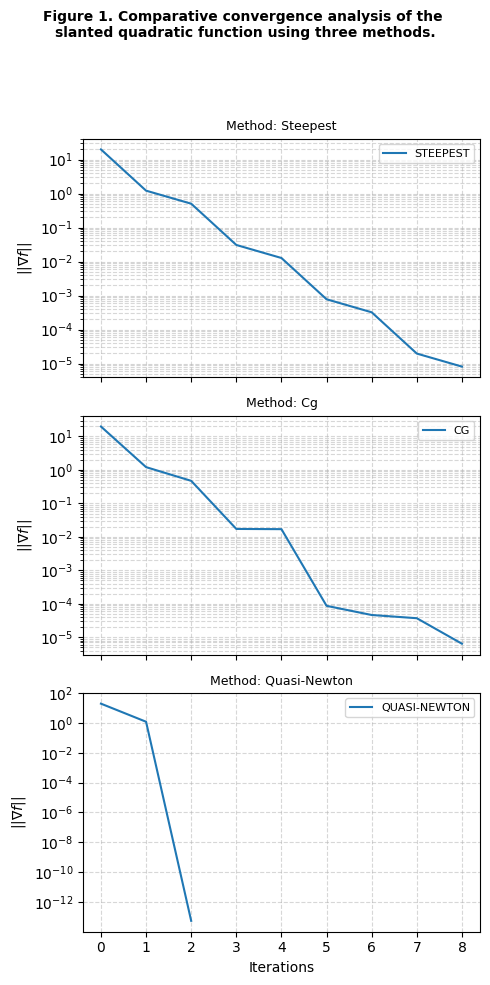

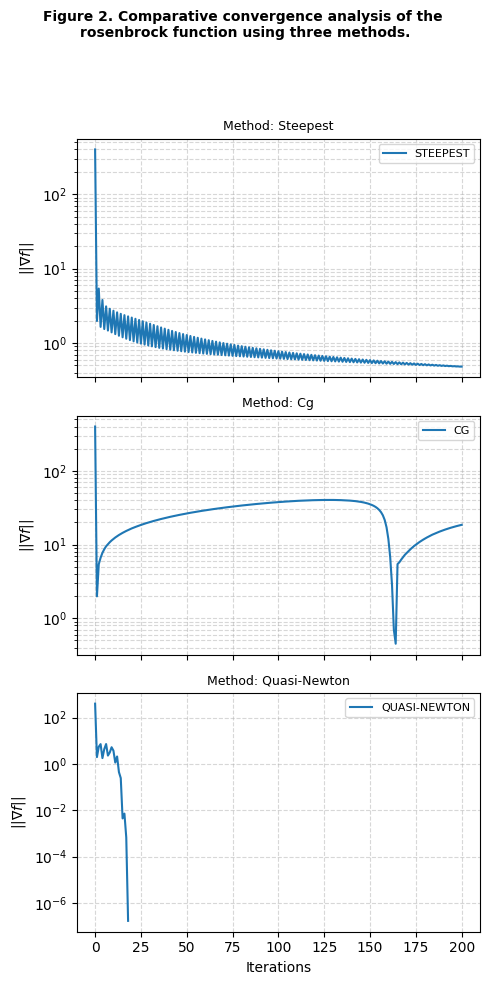

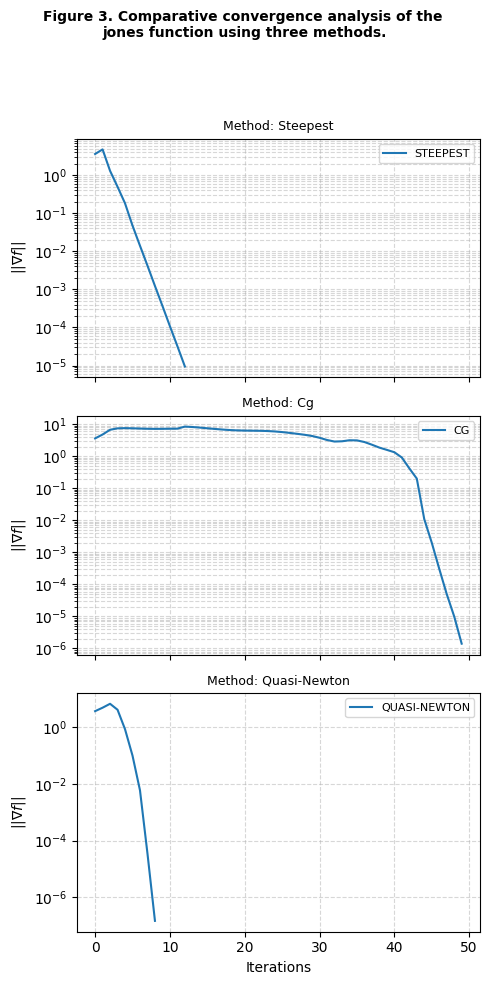

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Helper to reset call count ---
call_count = 0
def counted_f(x, func):
    global call_count
    call_count += 1
    return func(x)

# --- Problem 1.4: Results Table Generation ---
def run_all_benchmarks():
    test_functions = [
        ("Slanted Quadratic", slanted_quadratic, grad_slanted_quadratic, np.array([2.0, -6.0])),
        ("Rosenbrock", rosenbrock, grad_rosenbrock, np.array([0.0, 2.0])),
        ("Jones", jones, grad_jones, np.array([1.0, 1.0]))
    ]
    
    methods = ['steepest', 'cg', 'quasi-newton']
    results_table = {}

    for name, func, grad, x0 in test_functions:
        results_table[name] = {}
        
        for m in methods:
            global call_count
            call_count = 0
            # Wrap function to count calls
            f_to_run = lambda x: counted_f(x, func)
            
            # x_opt: optimal point, history: list of x values at each iteration
            x_opt, history, _ = run_optimizer(x0, f_to_run, grad, method=m)
            
            # Store (call_count, history, optimal_x, optimal_f)
            results_table[name][m] = (call_count, history, x_opt, func(x_opt))
            
        # Stand-alone Optimizer (Scipy BFGS)
        scipy_calls = 0
        def scipy_f(x):
            nonlocal scipy_calls
            scipy_calls += 1
            return func(x)
            
        res = minimize(scipy_f, x0, jac=grad, method='BFGS')
        results_table[name]['scipy'] = (scipy_calls, None, res.x, res.fun)

    return results_table

# --- Problem 1.5: Individual Convergence Plots ---
def plot_convergence(results):
    test_names = list(results.keys())
    grad_map = {
        "Slanted Quadratic": grad_slanted_quadratic,
        "Rosenbrock": grad_rosenbrock,
        "Jones": grad_jones
    }
    
    methods = ['steepest', 'cg', 'quasi-newton']
    
    for idx, name in enumerate(test_names, 1):
        g_func = grad_map[name]
        
        # Vertical stack, max width 5 inches to keep it compact
        fig, axes = plt.subplots(3, 1, figsize=(5, 10), sharex=True)
        
        fig.suptitle(f"Figure {idx}. Comparative convergence analysis of the \n"
                     f"{name.lower()} function using three methods.", 
                     fontsize=10, fontweight='bold', wrap=True)

        for i, method in enumerate(methods):
            ax = axes[i]
            history = results[name][method][1]
            metrics = [np.linalg.norm(g_func(x)) for x in history]
            
            ax.plot(range(len(metrics)), metrics, label=method.upper(), color='C0', linewidth=1.5)
            ax.set_yscale('log') 
            ax.set_ylabel(r"$||\nabla f||$")
            ax.set_title(f"Method: {method.title()}", fontsize=9)
            ax.grid(True, which="both", ls="--", alpha=0.5)
            ax.legend(fontsize=8, loc='upper right')

        axes[-1].set_xlabel("Iterations")
        plt.tight_layout(rect=[0, 0, 1, 0.93]) 
        plt.show()

# --- EXECUTION AND PRINTING ---
results_data = run_all_benchmarks()

# 1. Print Function Calls Table
print(f"{'Problem':<20} | {'SD':<5} | {'CG':<5} | {'QN':<5} | {'Scipy':<5}")
print("-" * 55)
for prob, data in results_data.items():
    print(f"{prob:<20} | {data['steepest'][0]:<5} | {data['cg'][0]:<5} | {data['quasi-newton'][0]:<5} | {data['scipy'][0]:<5}")

# 2. Print Optimal Values
print(f"\n{'Problem':<20} | {'Method':<12} | {'Optimal f(x*)':<15} | {'Point Found':<20}")
print("-" * 55)
for prob, methods_data in results_data.items():
    for m_name, m_results in methods_data.items():
        # m_results[3] is the optimal function value
        print(f"{prob:<20} | {m_name:<12} | {m_results[3]:.8e} | {m_results[2]}")

# 3. Generate Plots
plot_convergence(results_data)

**PROBLEM 1.6**

In [6]:
def rosenbrock_ndim(x):
    return np.sum(100.0 * (x[1:] - x[:-1]**2.0)**2.0 + (1.0 - x[:-1])**2.0)

def rosenbrock_ndim_jac(x):
    n = x.size
    grad = np.zeros_like(x)

    # First component
    grad[0] = -400.0 * x[0] * (x[1] - x[0]**2) - 2.0 * (1.0 - x[0])

    # Interior components
    if n > 2:
        grad[1:-1] = (200.0 * (x[1:-1] - x[:-2]**2) - 400.0 * x[1:-1] * (x[2:] - x[1:-1]**2) - 2.0 * (1.0 - x[1:-1]))

    # Last component
    grad[-1] = 200.0 * (x[-1] - x[-2]**2)

    return grad

# --- Optimization Execution for N-Dim Rosenbrock --- #

initial_conditions = [
    np.array([-0.3, 1.0, 1.0, 1.0]),
    np.array([-0.2, 1.0, 1.0, 1.0]),
    np.array([-0.2, 1.0, 1.0, 1.0, 1.0]),
    np.array([-0.1, 1.0, 1.0, 1.0, 1.0]),
]

print(f"{'Initial Condition':<35} | {'Final f(x)' :<12} | {'Min Type'}")
print("-" * 70)

for x0 in initial_conditions:
    res = minimize(rosenbrock_ndim, x0, method='BFGS', jac=rosenbrock_ndim_jac, options={'gtol': 1e-5, 'disp': False})

    min_type = "Global Minimum" if np.allclose(res.x, np.ones_like(x0), atol=1e-4) else "Local Minimum"

    print(f"{str(x0):<35} | {res.fun:<12.6e} | {min_type}")
    print(f" Optimal Solution: {res.x}\n")

Initial Condition                   | Final f(x)   | Min Type
----------------------------------------------------------------------
[-0.3  1.   1.   1. ]               | 3.701429e+00 | Local Minimum
 Optimal Solution: [-0.77565923  0.61309339  0.38206288  0.14597205]

[-0.2  1.   1.   1. ]               | 4.622679e-14 | Global Minimum
 Optimal Solution: [1.00000001 1.00000001 1.00000004 1.00000006]

[-0.2  1.   1.   1.   1. ]          | 3.930839e+00 | Local Minimum
 Optimal Solution: [-0.96205105  0.93573945  0.88071371  0.77787788  0.60509398]

[-0.1  1.   1.   1.   1. ]          | 4.665051e-16 | Global Minimum
 Optimal Solution: [1.         1.         1.         1.         1.00000001]

